## Load MNIST

In [1]:
# Load mnist dataset and pad the image to 32 * 32
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, transforms

transform = transforms.Compose([
    ToTensor(),                     # Convert image to tensor
    transforms.Pad(2, fill=0, padding_mode='constant')  # Pad the image to get 32x32 size
])

dataset = MNIST(root='./data', download = True, transform = transform)

dataset = [
    (image.repeat(3, 1, 1), label) # repeat the gray channel for creating pseudo color image of format C, H, W
    for image, label in dataset
]

digit_size = 32
image_size = 64
step_length = 0.2
N = len(dataset)

5


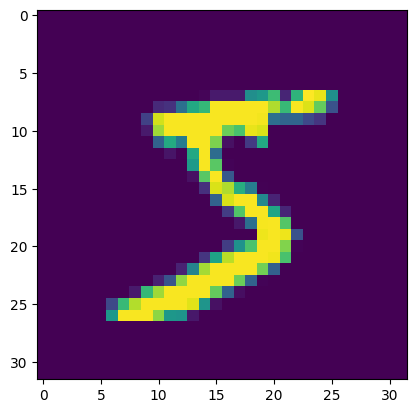

In [2]:
import matplotlib.pyplot as plt

image, label = dataset[0]
print(label)
plt.imshow(image[0])

## Create Random Trajectory

In [3]:
import numpy as np
import torch

def get_random_trajectory(seq_length):
    "Generate a trajectory"
    canvas_size = image_size - digit_size
    x, y, v_x, v_y = np.random.random(4)
    out_x, out_y = [], []
    
    for i in range(seq_length):
        # Take a step along velocity.
        y += v_y * step_length
        x += v_x * step_length

        # Bounce off edges.
        if x <= 0:
            x = 0
            v_x = -v_x
        if x >= 1.0:
            x = 1.0
            v_x = -v_x
        if y <= 0:
            y = 0
            v_y = -v_y
        if y >= 1.0:
            y = 1.0
            v_y = -v_y
        out_x.append(x * canvas_size)
        out_y.append(y * canvas_size)

    return torch.tensor(out_x, dtype=torch.uint8), torch.tensor(out_y, dtype=torch.uint8)

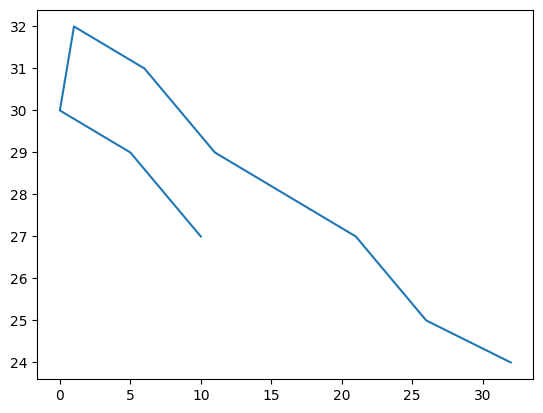

In [4]:
x,y = get_random_trajectory(10)
plt.plot(x,y)

In [5]:
def show_images_batch(images_tensor, num_rows=1):
    # Batch size (number of images), number of rows to display
    batch_size = images_tensor.size(0)
    num_cols = (batch_size + num_rows - 1) // num_rows  # Calculate needed columns, round up
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    
    # Flatten the Axes array if necessary
    axs = axs.flatten()
    
    for i in range(batch_size):
        # Only show images that exist in the batch
        img = images_tensor[i]  # Get image tensor
        if img.shape[0] == 1:  # If grayscale
            axs[i].imshow(img.squeeze(0), cmap='gray')
        else:  # Assume RGB or RGBA
            # Convert C, H, W to H, W, C for matplotlib
            img = img.permute(1, 2, 0)
            axs[i].imshow(img * 255)
        
        axs[i].axis('off')  # Turn off axes
    # Turn off axes for any unused subplots
    for ax in axs[batch_size:]:
        ax.axis('off')
    
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


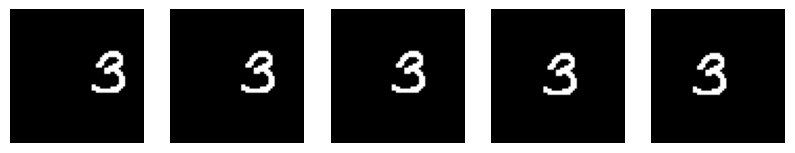

In [6]:
# get random image

from random import choice

def get_rand_img():
    "Get one digit randomly"
    img, _ = choice(dataset)
    return img

# Generate Moving digit

def generate_moving_digit(n_frames, image_size=64):
    "Move one digit on the canvas"
    digit_image = get_rand_img()
    xs, ys = get_random_trajectory(n_frames)
    canvas = torch.zeros((n_frames, digit_image.shape[0], image_size, image_size), dtype=torch.float)
    for i,(x,y) in enumerate(zip(xs,ys)):
        canvas[i, :, y:(y+digit_size),x:(x+digit_size)] = digit_image
    return canvas
    
image_sequence = generate_moving_digit(5)
show_images_batch(image_sequence)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


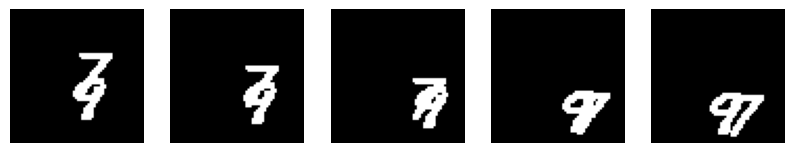

In [7]:
def generate_moving_digits(n_frames, digits=1):
    "generate multiple digits"
    return torch.stack([generate_moving_digit(n_frames) for n in range(digits)]).max(dim=0)[0]

digits = generate_moving_digits(5, 2)
show_images_batch(digits)

## Build Models

In [8]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import wandb
from copy import deepcopy

In [9]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_built():
    device = "mps"
else:
    device = "cpu"

device

'mps'

In [10]:
# Create Tensor Writer

from torch.utils.tensorboard import SummaryWriter
import os

def create_tensorboard_writer(exp_dir):
    tensorboard_dir = f"{exp_dir}/tensorboard"
    os.makedirs(tensorboard_dir, exist_ok=True)
    writer = SummaryWriter(tensorboard_dir)
    return writer

writer = create_tensorboard_writer("local/tensorboard")

In [11]:
from notebook.vae import VideoAutoencoderKL

vae = VideoAutoencoderKL(from_pretrained = "stabilityai/sd-vae-ft-ema", device=device)
latent_size = vae.get_latent_size((3, image_size, image_size))

In [12]:
# from notebook.t5 import T5Encoder

# text_encoder = T5Encoder(from_pretrained='DeepFloyd/t5-v1_1-xxl', shardformer=False, model_max_length=1, device=device)

from notebook.t5 import MNistEncoder
text_encoder = MNistEncoder(device)

In [13]:
vae.out_channels

4

In [17]:
from notebook.stdit import STDiT

model = STDiT(
    input_size=latent_size,
    in_channels=vae.out_channels,
    caption_channels=text_encoder.output_dim,
    model_max_length=text_encoder.model_max_length,
    dtype = "bf16",

    depth=16,
    hidden_size=32,
    patch_size=(1, 2, 2),
    num_heads=16
).to(device)

In [18]:
num_params = 0
num_params_trainable = 0
for p in model.parameters():
    num_params += p.numel()
    if p.requires_grad:
        num_params_trainable += p.numel()
num_params, num_params_trainable

(358144, 358144)

In [19]:
from notebook.iddpm import IDDPM

scheduler = IDDPM()

In [20]:
import torch.optim as optim

# Assuming `model` is your model and `cfg.lr` is the learning rate from your configuration
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4, weight_decay=0
)

In [32]:
res = text_encoder.encode(["1", "2"])

In [35]:
res['mask']

tensor([[1],
        [1]], device='mps:0')